<a href="https://colab.research.google.com/github/ZamantaEst/Pruebas-Saber-Pro-Colombia-Kaggle/blob/main/99_modelo_soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo CATBOST
## Conección con kaggle

In [2]:
from google.colab import files
files.upload()  # Subir kaggle.json

import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia
!unzip udea*.zip > /dev/null

Saving kaggle.json to kaggle (2).json
udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


##Librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Organización de los datos

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

y = train["RENDIMIENTO_GLOBAL"]
X = train.drop(columns=["RENDIMIENTO_GLOBAL"])
test_id = test["ID"]

##Procesmaiento

In [5]:
numeric_cols = ["INDICADOR_1","INDICADOR_2","INDICADOR_3","INDICADOR_4"]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
test[numeric_cols] = test[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("MISSING")
test[categorical_cols] = test[categorical_cols].fillna("MISSING")

#No hacemos labelencoder ya que catbost lo hace de forma interna

## Entrenamiento del modelo

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

!pip install catboost > /dev/null
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.2,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50)


print("Entrenando CatBoost...")
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=categorical_cols,
    verbose=100
)

Entrenando CatBoost...
0:	learn: 1.3509889	test: 1.3505403	best: 1.3505403 (0)	total: 37ms	remaining: 18.4s
100:	learn: 1.2131757	test: 1.2154116	best: 1.2154116 (100)	total: 1.99s	remaining: 7.87s
200:	learn: 1.2045362	test: 1.2096688	best: 1.2096688 (200)	total: 3.83s	remaining: 5.7s
300:	learn: 1.1992455	test: 1.2075165	best: 1.2075165 (300)	total: 5.65s	remaining: 3.73s
400:	learn: 1.1945910	test: 1.2061865	best: 1.2061697 (396)	total: 9.08s	remaining: 2.24s
499:	learn: 1.1907815	test: 1.2056385	best: 1.2056270 (495)	total: 10.9s	remaining: 0us
bestTest = 1.205627031
bestIteration = 495
Shrink model to first 496 iterations.


In [7]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
val_pool = Pool(X_val, y_val, cat_features=categorical_cols)

model = CatBoostClassifier(
    iterations=3000,
    loss_function='MultiClass',
    task_type="GPU"
)

model.randomized_search(
    {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.02, 0.03, 0.05],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'bagging_temperature': [0, 0.5, 1],
        'random_strength': [1, 2, 5, 10]
    },
    train_pool,
    cv=3,
    n_iter=5,
    verbose=1)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
1005:	learn: 1.1994222	test: 1.2091697	best: 1.2091691 (1004)	total: 19.3s	remaining: 38.2s
1006:	learn: 1.1994106	test: 1.2091648	best: 1.2091648 (1006)	total: 19.3s	remaining: 38.1s
1007:	learn: 1.1993910	test: 1.2091663	best: 1.2091648 (1006)	total: 19.3s	remaining: 38.1s
1008:	learn: 1.1993765	test: 1.2091658	best: 1.2091648 (1006)	total: 19.3s	remaining: 38.1s
1009:	learn: 1.1993635	test: 1.2091678	best: 1.2091648 (1006)	total: 19.3s	remaining: 38.1s
1010:	learn: 1.1993365	test: 1.2091620	best: 1.2091620 (1010)	total: 19.3s	remaining: 38s
1011:	learn: 1.1993159	test: 1.2091650	best: 1.2091620 (1010)	total: 19.4s	remaining: 38s
1012:	learn: 1.1993034	test: 1.2091598	best: 1.2091598 (1012)	total: 19.4s	remaining: 38s
1013:	learn: 1.1993013	test: 1.2091590	best: 1.2091590 (1013)	total: 19.4s	remaining: 38s
1014:	learn: 1.1992726	test: 1.2091358	best: 1.2091358 (1014)	total: 19.4s	remaining: 37.9s
1015:	learn: 1.199252

{'params': {'bagging_temperature': 0,
  'random_strength': 2,
  'depth': 6,
  'learning_rate': 0.05,
  'l2_leaf_reg': 1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
     

##Metricas


ACCURACY: 0.43228880866425995

Classification Report:
               precision    recall  f1-score   support

        alto       0.55      0.61      0.58     35124
        bajo       0.46      0.56      0.51     34597
  medio-alto       0.33      0.28      0.30     34324
  medio-bajo       0.33      0.26      0.30     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500



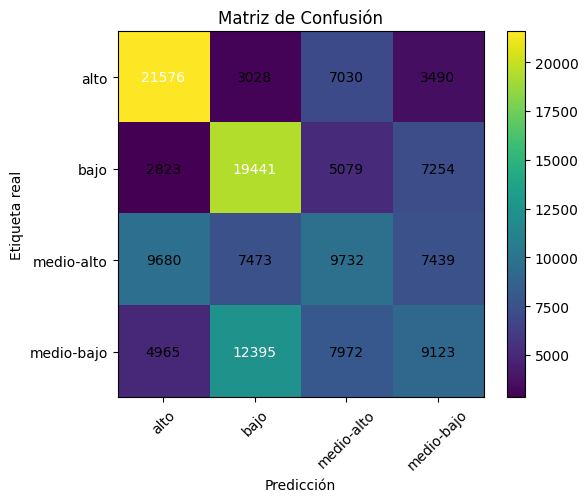

In [8]:
pred_val = model.predict(X_val)

print("\n==============================")
print("ACCURACY:", accuracy_score(y_val, pred_val))
print("==============================")

print("\nClassification Report:\n", classification_report(y_val, pred_val))
cm = confusion_matrix(y_val, pred_val)

#Matriz de confusión
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión")
plt.colorbar()

classes = np.unique(y_val)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.tight_layout()
plt.show()


##Prediccion final para entregable de kaggle

In [9]:
pred = model.predict(test).reshape(-1)

submission = pd.DataFrame({
    "ID": test_id,
    "RENDIMIENTO_GLOBAL": pred})

submission.to_csv("submission_catboost.csv", index=False)
print("\nArchivo submission_catboost.csv creado")

files.download("submission_catboost.csv")


Archivo submission_catboost.csv creado


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>